### First, let's import our modules and connect to the database/collection.

In [11]:
import json
import pandas as pd
import numpy as np

import pymongo
from pymongo import MongoClient

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

In [12]:
# Load in our parameters file
with open('../parameters.json') as f:
    params = json.load(f)

In [13]:
database = params['database']
duration_collection = params['duration_collection']

# Connect to our database/collection
client = MongoClient('localhost', 27017)
db = client[database]
duration_coll = db[duration_collection]

In [14]:
time_df = pd.DataFrame(list(duration_coll.find({},{'_id':0})))

time_df.head()

,duration,min_noon_sqr,min_since_midnight,start_timestamp,trip_id_iso
0,2341.0,481636,26,1.475912e+09,7253717_2016-10-08_4489K
1,2940.0,12321,609,1.475947e+09,7253845_2016-10-08_GHNYG
2,3450.0,729,747,1.475955e+09,7253837_2016-10-08_8Q6DP
3,3268.0,28900,890,1.475963e+09,7253830_2016-10-08_SR1KP
4,3274.0,96100,1030,1.475972e+09,7253823_2016-10-08_TDW9M


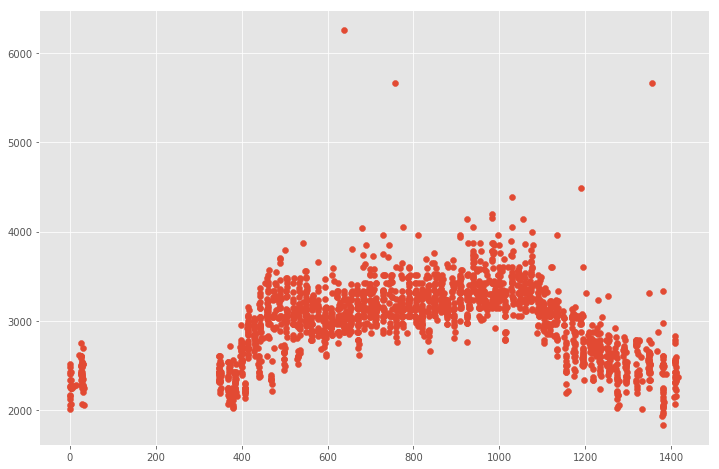

In [17]:
y = time_df['duration'].values.reshape(-1,1)
x = time_df['min_since_midnight'].values.reshape(-1,1)

fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(x, y);

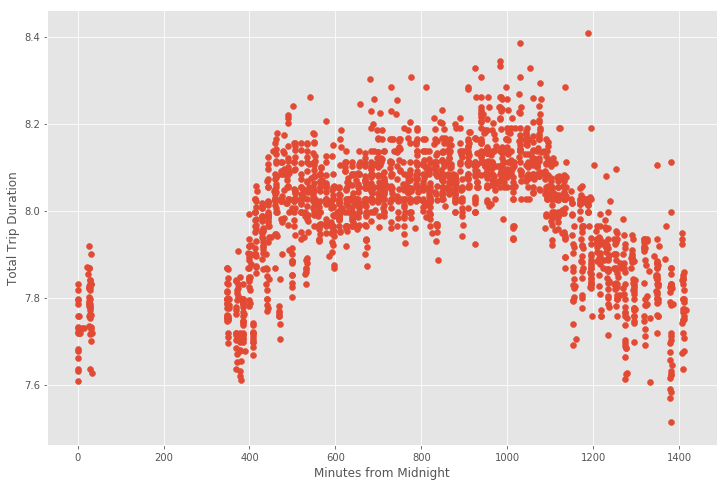

In [18]:
trimed_df = time_df[time_df['duration'] < 4500]

y = trimed_df['duration'].values.reshape(-1,1)
y = np.log(y)

x = trimed_df['min_since_midnight'].values.reshape(-1,1)
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(x, y)
ax.set_xlabel("Minutes from Midnight")
ax.set_ylabel("Total Trip Duration");

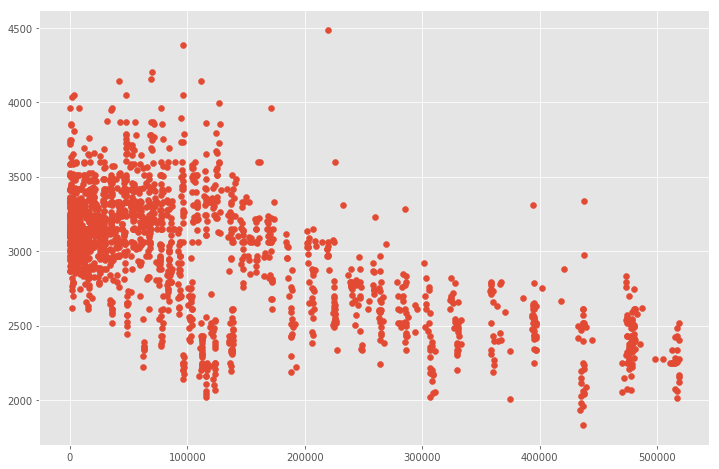

In [211]:
y = trimed_df['duration'].values.reshape(-1,1)
x = trimed_df['min_noon_sqr'].values.reshape(-1,1)
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(x, y);

In [212]:
y = trimed_df['duration'].values.reshape(-1,1)
X = trimed_df['min_noon_sqr'].values.reshape(-1,1)

scaler = StandardScaler()
X_norm = scaler.fit_transform(X)
scaler_y = StandardScaler()
y_norm = scaler_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_norm, y_norm)

# Build our model
ridge_cv = RidgeCV(alphas=[5,10,20,30], cv=20)
ridge_cv.fit(X_train, y_train)

#Score our model, R-Squared
r_squared = ridge_cv.score(X_test, y_test)

#Score our model, Root Mean Squared Error
y_predict = ridge_cv.predict(X_test)
rmse_norm = (mean_squared_error(y_test, y_predict))**.5
rmse_dev = scaler_y.inverse_transform([rmse_norm])
diff = rmse_dev[0] - scaler_y.mean_[0]

print ("R-squared: ", "{0:.2f}".format(r_squared))
print ('RMSE: ', "{0:.2f}".format(diff))

R-squared:  0.38
RMSE:  322.60


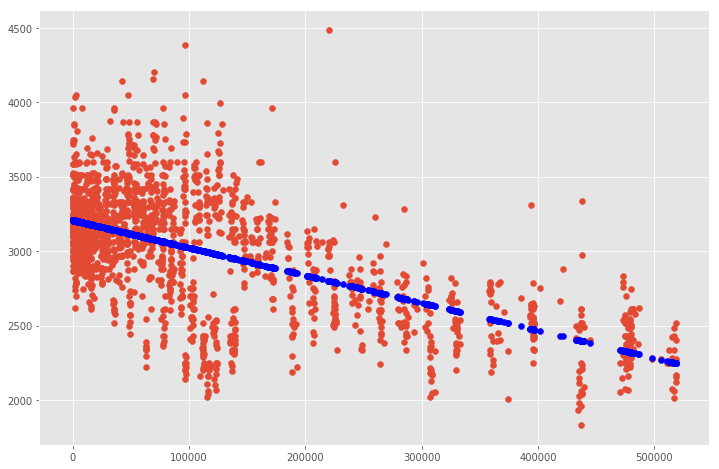

In [213]:
y_pred_totes = ridge_cv.predict(X_norm)
y_pred_stnd = scaler_y.inverse_transform(y_pred_totes)

y = trimed_df['duration'].values.reshape(-1,1)
x = trimed_df['min_noon_sqr'].values.reshape(-1,1)

fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(x, y)
ax.scatter(x, y_pred_stnd, c='blue');

In [214]:
y = trimed_df['duration'].values.reshape(-1,1)
X = trimed_df['min_noon_sqr'].values.reshape(-1,1)

scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

scaler_y = StandardScaler()
y_norm = scaler_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_norm, y_norm)

regr = RandomForestRegressor(n_estimators=50, max_depth=2)

crossed = cross_validate(regr, X_train, y_train.flatten(), cv=20, 
                         scoring=['neg_mean_squared_error','r2'], return_train_score=False)

r_squared = crossed['test_neg_mean_squared_error'].mean()

#Score our model, Root Mean Squared Error
rmse_norm = (abs(crossed['test_neg_mean_squared_error'].mean()))**.5
rmse_dev = scaler_y.inverse_transform([rmse_norm])
diff = rmse_dev[0] - scaler_y.mean_[0]

print ("R-squared: ", "{0:.2f}".format(r_squared))
print ('RMSE: ', "{0:.2f}".format(diff))

R-squared:  -0.57
RMSE:  304.82


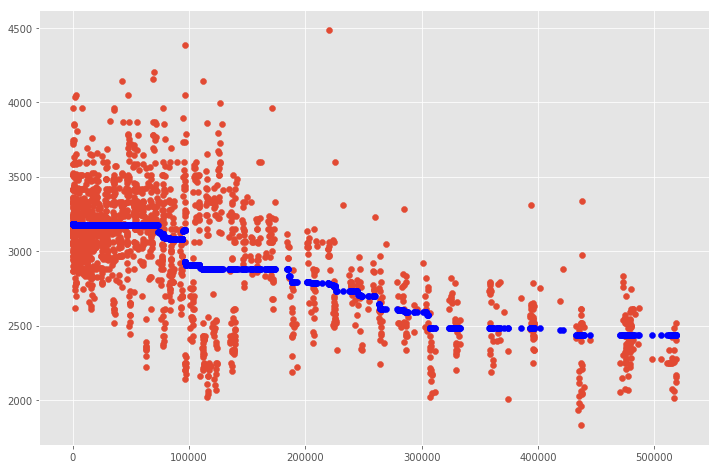

In [215]:
regr.fit(X_train, y_train)

y_pred_totes = regr.predict(X_norm)
y_pred_stnd = scaler_y.inverse_transform(y_pred_totes)

fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(x, y)
ax.scatter(x, y_pred_stnd, c='blue');

### Okay Cool! But how this relationship play out with different chunks of the trip?

### Let's start with two chunks:

In [218]:
two_chunk_df = pd.DataFrame(list(two_chunk_coll.find({},{'_id':0})))
two_chunk_df.head()

,avg_speed_chnk_1,avg_speed_chnk_2,chnk1_mfn_sq_chnk_1,chnk1_mfn_sq_chnk_2,seconds_chnk_1,seconds_chnk_2
0,5.563081,5.117909,481636,452929,1250.0,1027.0
1,5.051780,5.112077,12321,7396,1438.0,1428.0
2,4.878015,3.558431,729,2916,1560.0,1806.0
3,4.676721,3.959559,28900,39204,1682.0,1550.0
4,4.587672,3.931596,96100,114244,1678.0,1534.0


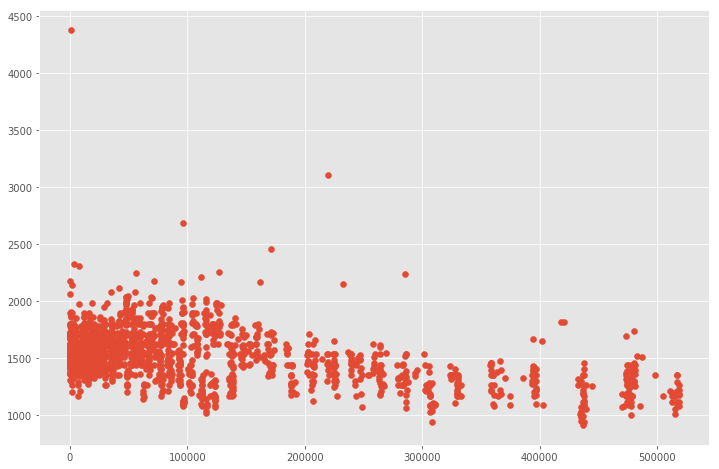

In [219]:
y = two_chunk_df['seconds_chnk_1'].values.reshape(-1,1)
x = two_chunk_df['chnk1_mfn_sq_chnk_1'].values.reshape(-1,1)
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(x, y);

### Just as before, we'll need to cleanup some outliers

In [220]:
mask = (two_chunk_df['seconds_chnk_1'] < 2500) & (two_chunk_df['seconds_chnk_2'] < 2500)
trimed_chnk_df = two_chunk_df[mask]

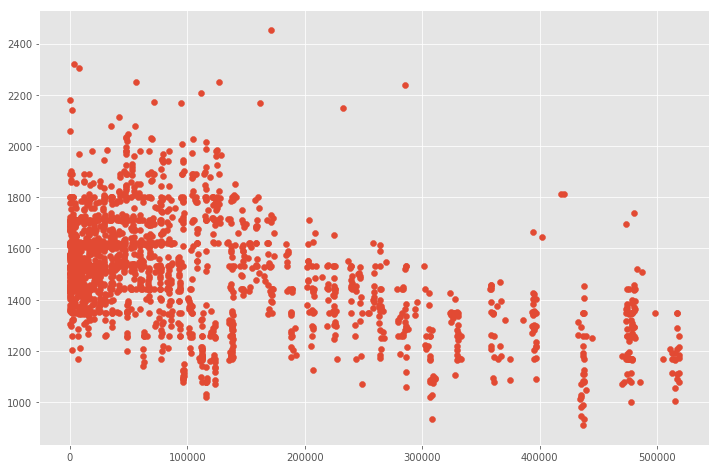

In [221]:
y = trimed_chnk_df['seconds_chnk_1'].values.reshape(-1,1)
x = trimed_chnk_df['chnk1_mfn_sq_chnk_1'].values.reshape(-1,1)
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(x, y);

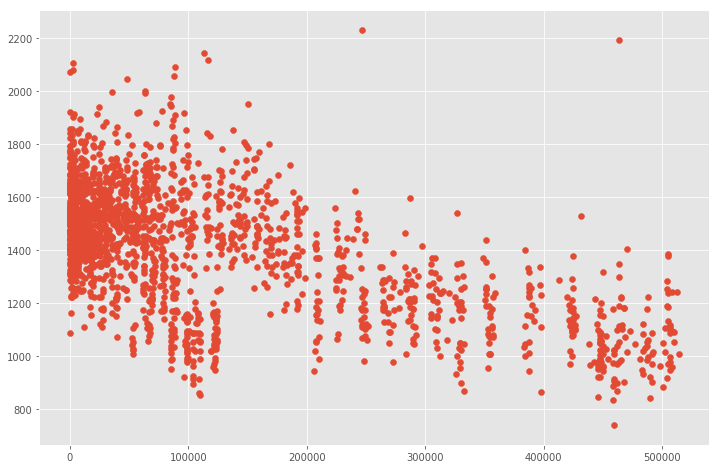

In [222]:
y = trimed_chnk_df['seconds_chnk_2'].values.reshape(-1,1)
x = trimed_chnk_df['chnk1_mfn_sq_chnk_2'].values.reshape(-1,1)
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(x, y);

### Cool! The relationship persists, more or less

### Let's try to make a prediction on the duration of the second chunk:

In [225]:
y = trimed_chnk_df['seconds_chnk_2'].values.reshape(-1,1)
X = trimed_chnk_df['chnk1_mfn_sq_chnk_2'].values.reshape(-1,1)

scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

scaler_y = StandardScaler()
y_norm = scaler_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_norm, y_norm)

regr = RandomForestRegressor(n_estimators=50, max_depth=2)

crossed = cross_validate(regr, X_train, y_train.flatten(), cv=20, 
                         scoring=['neg_mean_squared_error','r2'], return_train_score=False)

r_squared = crossed['test_neg_mean_squared_error'].mean()

#Score our model, Root Mean Squared Error
rmse_norm = (abs(crossed['test_neg_mean_squared_error'].mean()))**.5
rmse_dev = scaler_y.inverse_transform([rmse_norm])
diff = rmse_dev[0] - scaler_y.mean_[0]

print ("R-squared: ", "{0:.2f}".format(r_squared))
print ('RMSE: ', "{0:.2f}".format(diff))

R-squared:  -0.63
RMSE:  183.49


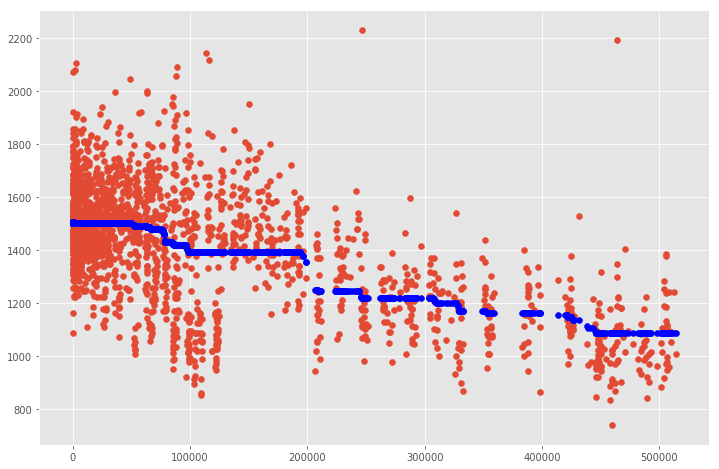

In [224]:
regr.fit(X_train, y_train)

y_pred_totes = regr.predict(X_norm)
y_pred_stnd = scaler_y.inverse_transform(y_pred_totes)

fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(x, y)
ax.scatter(x, y_pred_stnd, c='blue');

### Great! Unfortunately, the RMSE is not exactly half of our Total-Duration RMSE

### One more: Let's look at the effect on the 6 chunks:

In [230]:
six_chunk_df = pd.DataFrame(list(six_chunk_coll.find({},{'_id':0})))
six_chunk_df.head()

,avg_speed_chnk_1,avg_speed_chnk_2,avg_speed_chnk_3,avg_speed_chnk_4,avg_speed_chnk_5,avg_speed_chnk_6,mfn_sq_chnk_1,mfn_sq_chnk_2,mfn_sq_chnk_3,mfn_sq_chnk_4,mfn_sq_chnk_5,mfn_sq_chnk_6,seconds_chnk_1,seconds_chnk_2,seconds_chnk_3,seconds_chnk_4,seconds_chnk_5,seconds_chnk_6
0,5.782818,5.208333,5.694500,4.722200,5.158857,5.347313,481636,470596,462400,452929,446224,440896,416.0,350.0,440.0,270.0,243.0,481.0
1,4.974773,5.540111,4.678316,4.907333,4.120083,5.711080,12321,10609,9025,7396,6400,5184,450.0,424.0,480.0,352.0,410.0,576.0
2,5.145619,4.204591,5.277826,4.314800,2.800833,3.485710,729,1296,2025,2916,3721,4489,508.0,536.0,454.0,398.0,346.0,1020.0
3,6.510500,3.465524,4.514000,2.896810,2.648200,5.785130,28900,31684,35721,39204,43264,46225,464.0,640.0,540.0,524.0,404.0,540.0
4,4.621318,4.507500,4.638850,2.806895,2.991462,5.611150,96100,102400,108900,114244,121104,125316,568.0,598.0,468.0,544.0,350.0,596.0


### We'll just look at the third chunk:

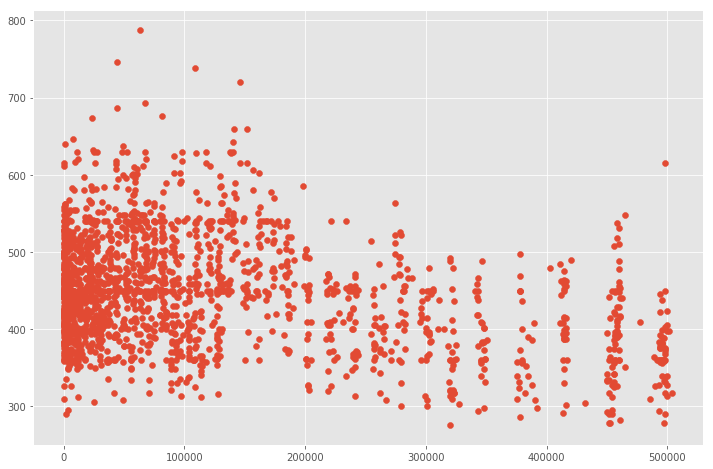

In [234]:
trimed_df = six_chunk_df[six_chunk_df['seconds_chnk_3'] < 900]

y = trimed_df['seconds_chnk_3'].values.reshape(-1,1)
x = trimed_df['mfn_sq_chnk_3'].values.reshape(-1,1)
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(x, y);

We can see that the relationship is much weaker.